In [29]:
# Import the necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define a new class that inherits from nn.Module
class VariableNetwork(nn.Module):
    # Define the constructor that takes the model as an argument
    def __init__(self, model):
        # Call the parent constructor
        super().__init__()
        # Assign the model to an attribute
        self.model = model
    
    # Override the forward function
    def forward(self, x):
        # Loop over the layers in the ModuleList
        for layer in self.model:
            # Apply the layer to the input
            x = layer(x)
        # Return the final output
        return x


# Define the functions to be approximated
def f(x1, x2, x3):
    return x1 + x2 + x3

def g(x1, x2, x3):
    return x1**2 + x2**3 + 0.5 * x3

def h(x1, x2, x3):
    return x3 * x1**(x2)


In [30]:

# Define the range and step size for the input variables
x1_range = (0, 10)
x2_range = (0, 10)
x3_range = (0, 10)
dx = 0.5

# Generate the input data by sampling uniformly from the ranges
x1 = np.arange(*x1_range, dx)
x2 = np.arange(*x2_range, dx)
x3 = np.arange(*x3_range, dx)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X = np.stack([X1.flatten(), X2.flatten(), X3.flatten()], axis=1)

# Compute the output data by applying the functions
Y_f = f(X[:, 0], X[:, 1], X[:, 2])
Y_g = g(X[:, 0], X[:, 1], X[:, 2])
Y_h = h(X[:, 0], X[:, 1], X[:, 2])

# Convert the input and output data to torch tensors
X = torch.from_numpy(X).float()
Y_f = torch.from_numpy(Y_f).float().unsqueeze(1)
Y_g = torch.from_numpy(Y_g).float().unsqueeze(1)
Y_h = torch.from_numpy(Y_h).float().unsqueeze(1)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = torch.utils.data.random_split(X, [train_size, test_size])
Y_f_train, Y_f_test = torch.utils.data.random_split(Y_f, [train_size, test_size])
Y_g_train, Y_g_test = torch.utils.data.random_split(Y_g, [train_size, test_size])
Y_h_train, Y_h_test = torch.utils.data.random_split(Y_h, [train_size, test_size])


In [31]:
## Define a function to create a neural network with given hyperparameters
#def create_network(input_size, hidden_size, output_size, activation):
#    # Create a sequential model with one hidden layer and one output layer
#    model = nn.Sequential(
#        nn.Linear(input_size, hidden_size),
#        activation(),
#        nn.Linear(hidden_size, output_size)
#    )
#    # Return the model
#    return model

# Let us have a variable number of hidden layers.
# Define a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activations):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes and activations
    for hidden_size, activation in zip(hidden_sizes, activations):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # Return the model
    return model


In [32]:

# Define a function to train a neural network with given hyperparameters and data
def train_network(model, optimizer, loss_fn, batch_size, epochs,
                  X_train, Y_train, X_test=None, Y_test=None):
    # Create a data loader for the training data
    train_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, Y_train),
        batch_size=batch_size,
        shuffle=True
    )
    # Initialize a list to store the training losses
    train_losses = []
    # Initialize a list to store the test losses if test data is given
    if X_test is not None and Y_test is not None:
        test_losses = []
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Initialize a variable to store the running loss for this epoch
        running_loss = 0.0
        # Loop over the batches of training data
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute the outputs from the inputs
            outputs = model(inputs)
            # Compute the loss from the outputs and targets
            loss = loss_fn(outputs, targets)
            # Backward pass: compute the gradients from the loss
            loss.backward()
            # Update the parameters using the optimizer
            optimizer.step()
            # Accumulate the running loss
            running_loss += loss.item()
        # Compute and append the average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        # Print the progress
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
        # If test data is given, compute and append the test loss for this epoch
        if X_test is not None and Y_test is not None:
            # Compute the outputs from the test inputs
            outputs = model(X_test)
            # Compute the loss from the outputs and test targets
            loss = loss_fn(outputs, Y_test)
            # Append the test loss
            test_loss = loss.item()
            test_losses.append(test_loss)
            # Print the progress
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
    # Return the train and test losses if test data is given, otherwise return only train losses
    if X_test is not None and Y_test is not None:
        return train_losses, test_losses
    else:
        return train_losses


In [41]:

# Define a function to plot the losses during training
def plot_losses(train_losses, test_losses=None, function_name=None):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the train losses
    ax.plot(train_losses, label="Train Loss")
    # If test losses are given, plot them as well
    if test_losses is not None:
        ax.plot(test_losses, label="Test Loss")
    # Set the title, labels, and legend
    ax.set_title("Losses during Training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    # Save and show the plot
    plt.savefig(f"losses_{function_name}.png")
    plt.show()


In [43]:

# Define a function to plot the predictions versus the true values
def plot_predictions(model, X, Y_true, function_name):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Compute the predictions from the inputs
    Y_pred = model(X).detach().numpy()
    # Plot the predictions and the true values as scatter plots
    ax.scatter(Y_true, Y_pred, label="Predictions", s=2, alpha=0.3)
    ax.scatter(Y_true, Y_true, label="True Values", s=2, alpha=0.3)
    # Set the title, labels, and legend
    ax.set_title("Predictions versus True Values")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    # Save and show the plot
    plt.savefig(f"predictions_{function_name}.png")
    plt.show()

Approximating function f
Epoch 1, Train Loss: 6.5687
Epoch 1, Test Loss: 0.0085
Epoch 2, Train Loss: 0.0055
Epoch 2, Test Loss: 0.0075
Epoch 3, Train Loss: 0.0042
Epoch 3, Test Loss: 0.0022
Epoch 4, Train Loss: 0.0019
Epoch 4, Test Loss: 0.0015
Epoch 5, Train Loss: 0.0015
Epoch 5, Test Loss: 0.0016
Epoch 6, Train Loss: 0.0011
Epoch 6, Test Loss: 0.0012
Epoch 7, Train Loss: 0.0010
Epoch 7, Test Loss: 0.0007
Epoch 8, Train Loss: 0.0012
Epoch 8, Test Loss: 0.0007
Epoch 9, Train Loss: 0.0007
Epoch 9, Test Loss: 0.0006
Epoch 10, Train Loss: 0.0007
Epoch 10, Test Loss: 0.0020
Epoch 11, Train Loss: 0.0017
Epoch 11, Test Loss: 0.0016
Epoch 12, Train Loss: 0.0009
Epoch 12, Test Loss: 0.0010
Epoch 13, Train Loss: 0.0005
Epoch 13, Test Loss: 0.0013
Epoch 14, Train Loss: 0.0027
Epoch 14, Test Loss: 0.0024
Epoch 15, Train Loss: 0.0008
Epoch 15, Test Loss: 0.0015
Epoch 16, Train Loss: 0.0048
Epoch 16, Test Loss: 0.0018
Epoch 17, Train Loss: 0.0028
Epoch 17, Test Loss: 0.0152
Epoch 18, Train Loss: 0.

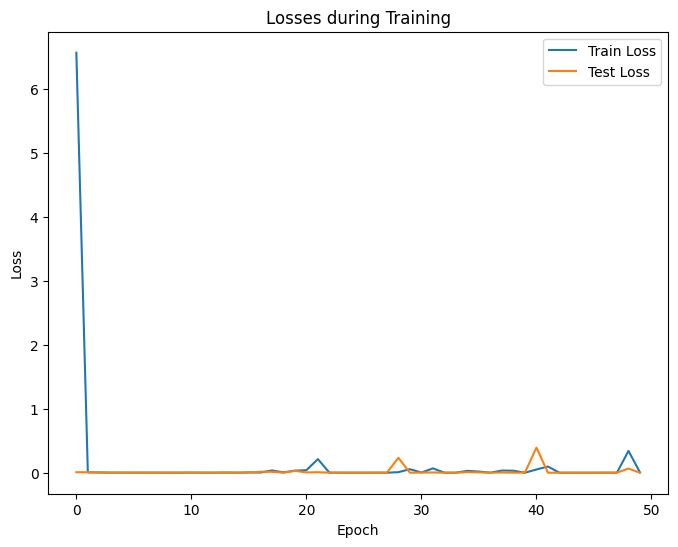

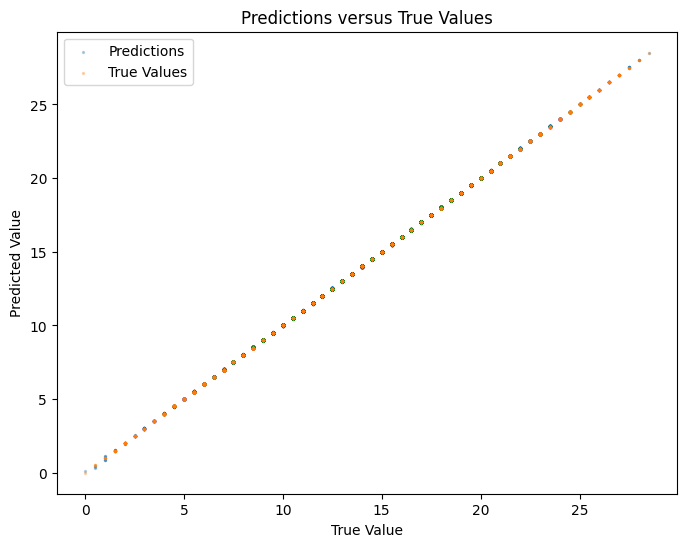

Approximating function g
Epoch 1, Train Loss: 24835.3733
Epoch 1, Test Loss: 4344.1709
Epoch 2, Train Loss: 1456.4411
Epoch 2, Test Loss: 226.6425
Epoch 3, Train Loss: 180.8524
Epoch 3, Test Loss: 54.3094
Epoch 4, Train Loss: 63.2497
Epoch 4, Test Loss: 30.0984
Epoch 5, Train Loss: 69.9100
Epoch 5, Test Loss: 789.2170
Epoch 6, Train Loss: 201.8206
Epoch 6, Test Loss: 21.6876
Epoch 7, Train Loss: 43.2870
Epoch 7, Test Loss: 11.7097
Epoch 8, Train Loss: 16.8482
Epoch 8, Test Loss: 8.8427
Epoch 9, Train Loss: 16.5597
Epoch 9, Test Loss: 7.4113
Epoch 10, Train Loss: 162.2813
Epoch 10, Test Loss: 75.3114
Epoch 11, Train Loss: 23.4090
Epoch 11, Test Loss: 7.9475
Epoch 12, Train Loss: 9.5882
Epoch 12, Test Loss: 5.6857
Epoch 13, Train Loss: 8.9839
Epoch 13, Test Loss: 15.4902
Epoch 14, Train Loss: 32.5431
Epoch 14, Test Loss: 496.7703
Epoch 15, Train Loss: 212.5025
Epoch 15, Test Loss: 634.9135
Epoch 16, Train Loss: 168.6903
Epoch 16, Test Loss: 7.1579
Epoch 17, Train Loss: 15.5359
Epoch 17, 

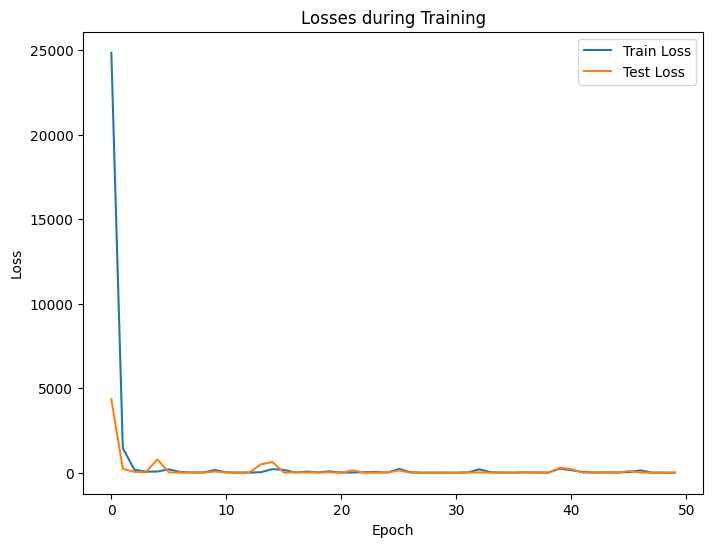

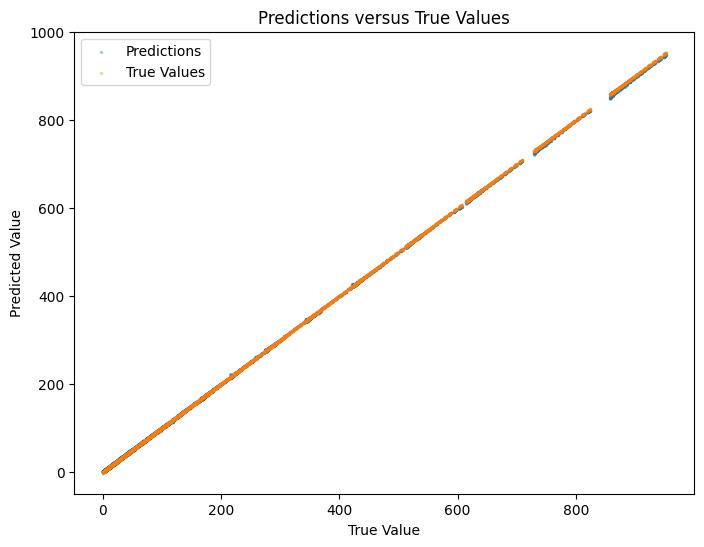

Approximating function h
Epoch 1, Train Loss: 500421184994555200.0000
Epoch 1, Test Loss: 499713638093815808.0000
Epoch 2, Train Loss: 495309986849099904.0000
Epoch 2, Test Loss: 488038989270351872.0000
Epoch 3, Train Loss: 484583109759078528.0000
Epoch 3, Test Loss: 482465427390201856.0000
Epoch 4, Train Loss: 481937923999442944.0000
Epoch 4, Test Loss: 481404329949921280.0000
Epoch 5, Train Loss: 480878266739006080.0000
Epoch 5, Test Loss: 480125735365771264.0000
Epoch 6, Train Loss: 479756186715947008.0000
Epoch 6, Test Loss: 479028766358634496.0000
Epoch 7, Train Loss: 478642208521626560.0000
Epoch 7, Test Loss: 477931247595683840.0000
Epoch 8, Train Loss: 477602042561513408.0000
Epoch 8, Test Loss: 476868432168484864.0000
Epoch 9, Train Loss: 476520572124252864.0000
Epoch 9, Test Loss: 475796477050880000.0000
Epoch 10, Train Loss: 475563691189236416.0000
Epoch 10, Test Loss: 474756407770480640.0000
Epoch 11, Train Loss: 474358076929898176.0000
Epoch 11, Test Loss: 4735898602931486

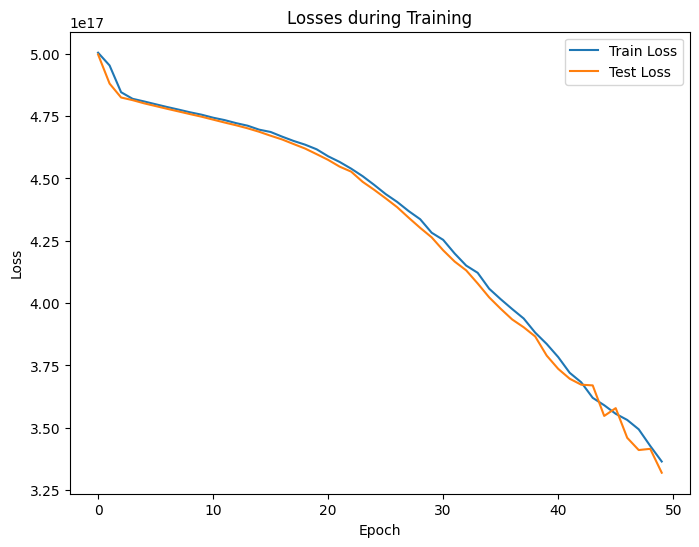

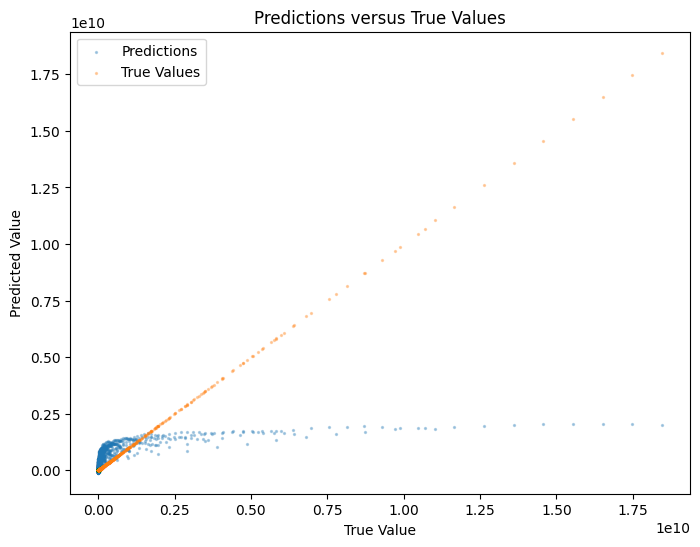

In [44]:

# Define a list of functions to be approximated
functions = [f, g, h]
# Define a list of function names for printing and plotting purposes
function_names = ["f", "g", "h"]
# Define a list of output tensors for each function
outputs = [Y_f, Y_g, Y_h]
# Define a list of output tensors for each function for train and test sets
outputs_train = [Y_f_train, Y_g_train, Y_h_train]
outputs_test = [Y_f_test, Y_g_test, Y_h_test]

# Loop over each function to be approximated
for i in range(len(functions)):
    # Print the function name
    print(f"Approximating function {function_names[i]}")
    # Create a neural network with given hyperparameters
    input_size = 3 # The number of input variables (x1, x2, x3)
    hidden_size = 32 # The number of units in the hidden layer
    output_size = 1 # The number of output variables (y)
    activation = nn.ReLU # The activation function for the hidden layer
    # Create a network with 3 hidden layers and ReLU activations
    hidden_sizes = [32, 64, 128]
    activations = [nn.ReLU, nn.ReLU, nn.ReLU]
    model = create_network(input_size, output_size,
                        hidden_sizes, activations)
    # Create an instance of VariableNetwork by passing the model
    network = VariableNetwork(model)

    # Create an optimizer with given hyperparameters
    optimizer = optim.Adam(network.parameters(), lr=0.01)
    # Create a loss function with given hyperparameters
    loss_fn = nn.MSELoss()
    # Train the network with given hyperparameters and data
    batch_size = 64 # The number of samples in each batch
    epochs = 50 # The number of times to loop over the whole dataset
    train_losses, test_losses = train_network(network, optimizer, loss_fn,
                                            batch_size, epochs,
                                            X_train.dataset, outputs_train[i].dataset,
                                            X_test.dataset, outputs_test[i].dataset)
    # Plot the losses during training
    plot_losses(train_losses, test_losses, function_names[i])
    # Plot the predictions versus the true values
    plot_predictions(network, X, outputs[i], function_names[i])
    # Save the network
    torch.save(network, f"network{function_names[i]}.pt")
